In [1]:
import jax
import jax.numpy as jnp
import flax.linen as nn
import tensorflow_datasets as tfds
from flax.training import train_state
import optax
from jax import random
import matplotlib.pyplot as plt
import pickle


In [2]:
class SimpleCNN(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Conv(features=32, kernel_size=(3, 3))(x)
        x = nn.relu(x)
        x = nn.max_pool(x, (2, 2))
        x = nn.Conv(features=64, kernel_size=(3, 3))(x)
        x = nn.relu(x)
        x = nn.max_pool(x, (2, 2))
        x = x.reshape((x.shape[0], -1))
        x = nn.Dense(features=512)(x)
        x = nn.relu(x)
        x = nn.Dense(features=10)(x)
        return x

In [3]:
def create_train_state(rng, learning_rate, momentum):
    cnn = SimpleCNN()
    params = cnn.init(rng, jnp.ones([1, 32, 32, 3]))['params']
    tx = optax.sgd(learning_rate, momentum)
    return train_state.TrainState.create(apply_fn=cnn.apply, params=params, tx=tx)

def cross_entropy_loss(logits, labels):
    one_hot_labels = jax.nn.one_hot(labels, num_classes=10)
    return -jnp.mean(jnp.sum(one_hot_labels * jax.nn.log_softmax(logits), axis=-1))

def compute_accuracy(logits, labels):
    return jnp.mean(jnp.argmax(logits, -1) == labels)


In [4]:
@jax.jit
def train_step(state, batch):
    def loss_fn(params):
        logits = state.apply_fn({'params': params}, batch['image'])
        loss = cross_entropy_loss(logits, batch['label'])
        return loss
    grad_fn = jax.value_and_grad(loss_fn)
    loss, grads = grad_fn(state.params)
    state = state.apply_gradients(grads=grads)
    return state, loss

In [5]:
@jax.jit
def eval_step(state, batch):
    logits = state.apply_fn({'params': state.params}, batch['image'])
    loss = cross_entropy_loss(logits, batch['label'])
    accuracy = compute_accuracy(logits, batch['label'])
    return loss, accuracy

In [6]:
def load_data():
    ds_builder = tfds.builder('cifar10')
    ds_builder.download_and_prepare()
    train_ds = tfds.as_numpy(ds_builder.as_dataset(split='train', batch_size=-1))
    test_ds = tfds.as_numpy(ds_builder.as_dataset(split='test', batch_size=-1))
    return train_ds, test_ds

In [9]:
def train_model():
    # Load and preprocess data
    train_ds, test_ds = load_data()
    train_images, train_labels = jax.numpy.array(train_ds['image']) / 255.0, jax.numpy.array(train_ds['label'])
    test_images, test_labels = jax.numpy.array(test_ds['image']) / 255.0, jax.numpy.array(test_ds['label'])
    rng = random.PRNGKey(0)
    rng, init_rng = random.split(rng)
    state = create_train_state(init_rng, learning_rate=0.001, momentum=0.9)

    num_epochs = 50
    batch_size = 64
    num_train_samples = len(train_images)
    steps_per_epoch = num_train_samples // batch_size

    train_losses = []
    test_losses = []
    test_accuracies = []

    for epoch in range(num_epochs):
        for i in range(steps_per_epoch):
            batch_start = i * batch_size
            batch_end = batch_start + batch_size
            batch = {'image': train_images[batch_start:batch_end], 'label': train_labels[batch_start:batch_end]}
            state, loss = train_step(state, batch)

        train_losses.append(loss)

        # Evaluation
        test_batch = {'image': test_images, 'label': test_labels}
        test_loss, test_accuracy = eval_step(state, test_batch)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

        print(f'Epoch {epoch + 1}, Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}, Test Accuracy: {test_accuracies[-1]:.4f}')

    # Save the model parameters
    with open('model_params.pkl', 'wb') as f:
        pickle.dump(state.params, f)

    return train_losses, test_losses, test_accuracies

In [10]:
train_losses, test_losses, test_accuracies = train_model()

Epoch 1, Train Loss: 1.2774, Test Loss: 1.4381, Test Accuracy: 0.4831
Epoch 2, Train Loss: 1.0870, Test Loss: 1.2753, Test Accuracy: 0.5387
Epoch 3, Train Loss: 0.9724, Test Loss: 1.1618, Test Accuracy: 0.5917
Epoch 4, Train Loss: 0.8962, Test Loss: 1.0858, Test Accuracy: 0.6218
Epoch 5, Train Loss: 0.8317, Test Loss: 1.0343, Test Accuracy: 0.6401
Epoch 6, Train Loss: 0.7559, Test Loss: 1.0060, Test Accuracy: 0.6487
Epoch 7, Train Loss: 0.6756, Test Loss: 0.9821, Test Accuracy: 0.6583
Epoch 8, Train Loss: 0.6016, Test Loss: 0.9708, Test Accuracy: 0.6637
Epoch 9, Train Loss: 0.5183, Test Loss: 0.9602, Test Accuracy: 0.6716
Epoch 10, Train Loss: 0.4295, Test Loss: 0.9582, Test Accuracy: 0.6792
Epoch 11, Train Loss: 0.3463, Test Loss: 0.9687, Test Accuracy: 0.6835
Epoch 12, Train Loss: 0.3086, Test Loss: 1.0165, Test Accuracy: 0.6798
Epoch 13, Train Loss: 0.2552, Test Loss: 1.0476, Test Accuracy: 0.6796
Epoch 14, Train Loss: 0.2951, Test Loss: 1.1564, Test Accuracy: 0.6711
Epoch 15, Train

Text(0.5, 1.0, 'Loss over epochs')

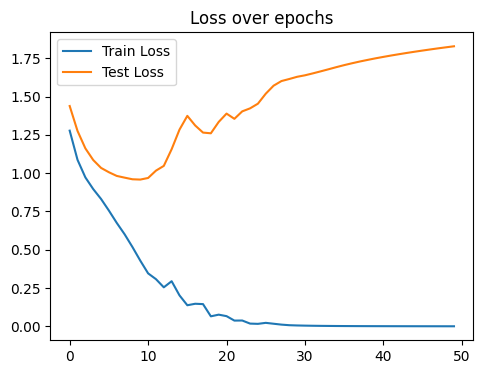

In [11]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.legend()
plt.title('Loss over epochs')


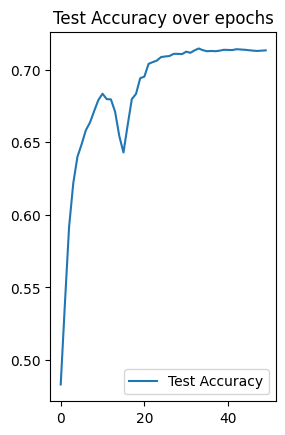

In [12]:
plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy')
plt.legend()
plt.title('Test Accuracy over epochs')
plt.show()